In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import tqdm
from time import sleep
import time
from PIL import Image
from io import BytesIO
from adjustText import adjust_text
from scipy.interpolate import interp1d

In [2]:
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name, get_teams, find_team_name_by_id
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail

In [9]:
from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats


In [10]:
miami_id = find_teams_by_full_name("Miami Heat")[0]['id']

bucks_id = find_teams_by_full_name("Milwaukee Bucks")[0]['id']

In [4]:
bball_gray = '#312f30'
bball_white = '#dddee0'
bball_orange = '#f87c24'
bball_light_orange = '#fbaf7b'

### Efficiency

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

def plot_radar(first_data, second_data, title, first_label, second_label, first_color, second_color):
    # number of variable
    categories=list(first_data.tolist())
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    fig = plt.figure(figsize=(12, 12))
    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], [item.replace("_", " ") for item in first_data.index.tolist()])
    for label,i in zip(ax.get_xticklabels(),range(0,len(angles))):

        angle_rad=angles[i]
        if angle_rad <= pi/2:
            ha= 'left'
            va= "bottom"
            angle_text=angle_rad*(-180/pi)+90
        elif pi/2 < angle_rad <= pi:
            ha= 'left'
            va= "top"
            angle_text=angle_rad*(-180/pi)+90
        elif pi < angle_rad <= (3*pi/2):
            ha= 'right'
            va= "top"  
            angle_text=angle_rad*(-180/pi)-90
        else:
            ha= 'right'
            va= "bottom"
            angle_text=angle_rad*(-180/pi)-90
        label.set_rotation(angle_text)
        label.set_verticalalignment(va)
        label.set_horizontalalignment(ha)


    # Draw ylabels
    ax.set_rlabel_position(0)
    #items = [item / 10 for item in range(0, 55, 10)]
    #plt.yticks(items, map(str, items), size=12)
    #ax.spines['polar'].set_color('#cbcbcb')
    #ax.spines['polar'].set_linewidth('1')
    max_val = max(first_data.max(), second_data.max())
    plt.ylim(0, max_val + 0.05 * max_val)
    ax.spines['polar'].set_visible(False)

    plt.title(title, color=bball_orange, size=20)
    values=first_data.tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=first_label, color=first_color)
    ax.fill(angles, values, first_color, alpha=0.4)

    values=second_data.tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=second_label, color=second_color)
    ax.fill(angles, values, second_color, alpha=0.4)
    legend = plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=14)

    ticks = ax.get_xticklabels()
    for tick in ticks:
        tick.set_color(bball_orange)
    ticks = ax.get_yticklabels()
    for tick in ticks:
        tick.set_color(bball_orange)
    #ax.set_yticklabels(f"{item}%" for item in range(5, 35, 5))

    frame = legend.get_frame()
    frame.set_facecolor(bball_gray)
    frame.set_linewidth(2)
    frame.set_edgecolor(bball_light_orange)
    for text in legend.get_texts():
        text.set_color(bball_light_orange)

    ax.set_frame_on(False)
    ax.set_facecolor(bball_gray)
    fig.set_facecolor(bball_gray)

In [35]:
def get_tracking_data(team_id):
    interesting_columns = ['DRIVE_PTS',
       'CATCH_SHOOT_PTS', 'PULL_UP_PTS', 'PAINT_TOUCH_PTS',
       'POST_TOUCH_PTS', 'ELBOW_TOUCH_PTS']
    tracking_stats = LeagueDashPtStats(pt_measure_type='Efficiency', season_type_all_star="Playoffs", per_mode_simple='PerGame')

    teams_tracking_df = tracking_stats.get_data_frames()[0]
    playoff_tracking_df = teams_tracking_df.loc[teams_tracking_df.TEAM_ID == team_id].loc[:, interesting_columns].iloc[0]
    
    tracking_stats = LeagueDashPtStats(pt_measure_type='Efficiency', per_mode_simple='PerGame')

    teams_tracking_df = tracking_stats.get_data_frames()[0]
    regular_tracking_df = teams_tracking_df.loc[teams_tracking_df.TEAM_ID == team_id].loc[:, interesting_columns].iloc[0]
    
    
    return regular_tracking_df, playoff_tracking_df

In [11]:
play_types = [
    "Postup",
    "Spotup",
    "PRBallHandler",
    "PRRollman",
    "Transition",
    "Cut",
    "OffScreen",
    "OffRebound",
    "Handoff",
    "Isolation",
]

def get_playtype_playoff_data(team_id):
    play_type_dict = {}
    for play in play_types:
        synergy = SynergyPlayTypes(player_or_team_abbreviation="T", play_type_nullable=play, type_grouping_nullable="offensive", per_mode_simple="PerGame", season='2019-20', season_type_all_star='Playoffs')
        synergy_df = synergy.get_data_frames()[0]
        play_type_dict[play] = synergy_df
        time.sleep(1)
        
    team_play_type_playoffs = []

    for play in play_type_dict:
        cur_df = play_type_dict[play]
        team_play_type_playoffs.append(cur_df.loc[cur_df.TEAM_ID == team_id])
        
    teams_pt_df = pd.concat(team_play_type_playoffs).loc[:, ['PLAY_TYPE', 'PTS']].pivot_table(index='PLAY_TYPE', values='PTS').transpose().iloc[0]
    return teams_pt_df
    
def get_playtype_regular_data(team_id):
    
    play_type_dict = {}
    for play in play_types:
        synergy = SynergyPlayTypes(player_or_team_abbreviation="T", play_type_nullable=play, type_grouping_nullable="offensive", per_mode_simple="PerGame", season='2019-20')
        synergy_df = synergy.get_data_frames()[0]
        play_type_dict[play] = synergy_df
        time.sleep(1)
        
    team_play_type_regular = []

    for play in play_type_dict:
        cur_df = play_type_dict[play]
        team_play_type_regular.append(cur_df.loc[cur_df.TEAM_ID == team_id])
        
    teams_pt_df = pd.concat(team_play_type_regular).loc[:, ['PLAY_TYPE', 'PTS']].pivot_table(index='PLAY_TYPE', values='PTS').transpose().iloc[0]
    return teams_pt_df


## Tracking

In [36]:
bucks_regular_tracking, bucks_playoff_tracking = get_tracking_data(bucks_id)

In [37]:
miami_regular_tracking, miami_playoff_tracking = get_tracking_data(miami_id)

In [15]:
bucks_regular_playtype = get_playtype_regular_data(team_id=bucks_id)
bucks_playoff_playtype = get_playtype_playoff_data(team_id=bucks_id)

In [16]:
miami_regular_playtype = get_playtype_regular_data(team_id=miami_id)
miami_playoff_playtype = get_playtype_playoff_data(team_id=miami_id)

In [17]:
miami_color = '#98002E'
miami_secondary_blue = '#41B6E6'
miami_secondary = '#DB3EB1'

In [18]:
bucks_color = '#00471B'
bucks_cream = '#EEE1C6'

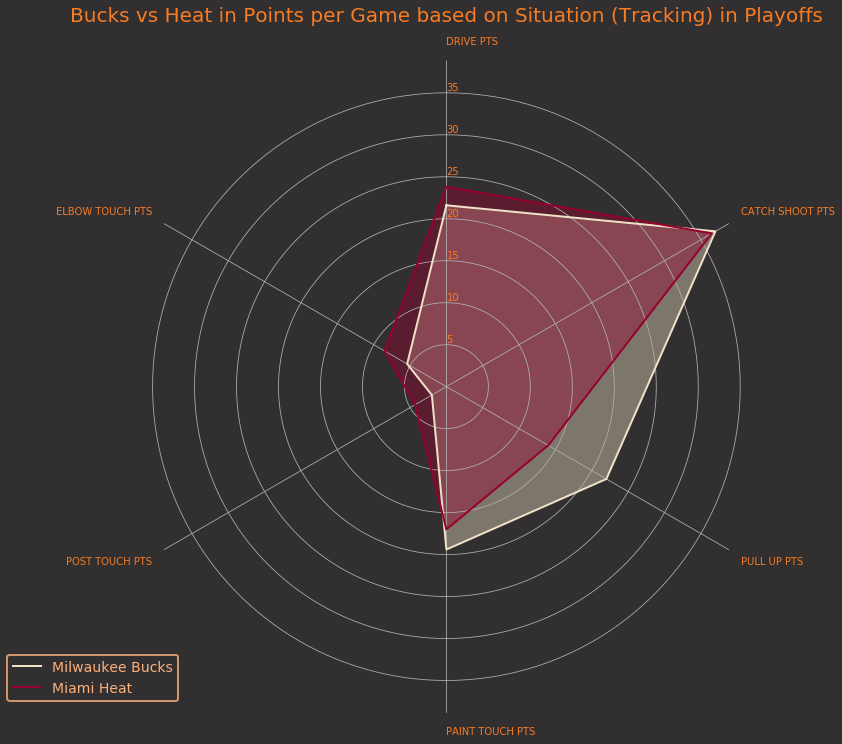

In [38]:
plot_radar(
    first_data=bucks_playoff_tracking,
    first_label='Milwaukee Bucks',
    first_color=bucks_cream,
    second_data=miami_playoff_tracking,
    second_label='Miami Heat',
    second_color=miami_color,
    title='Bucks vs Heat in Points per Game based on Situation (Tracking) in Playoffs'
)

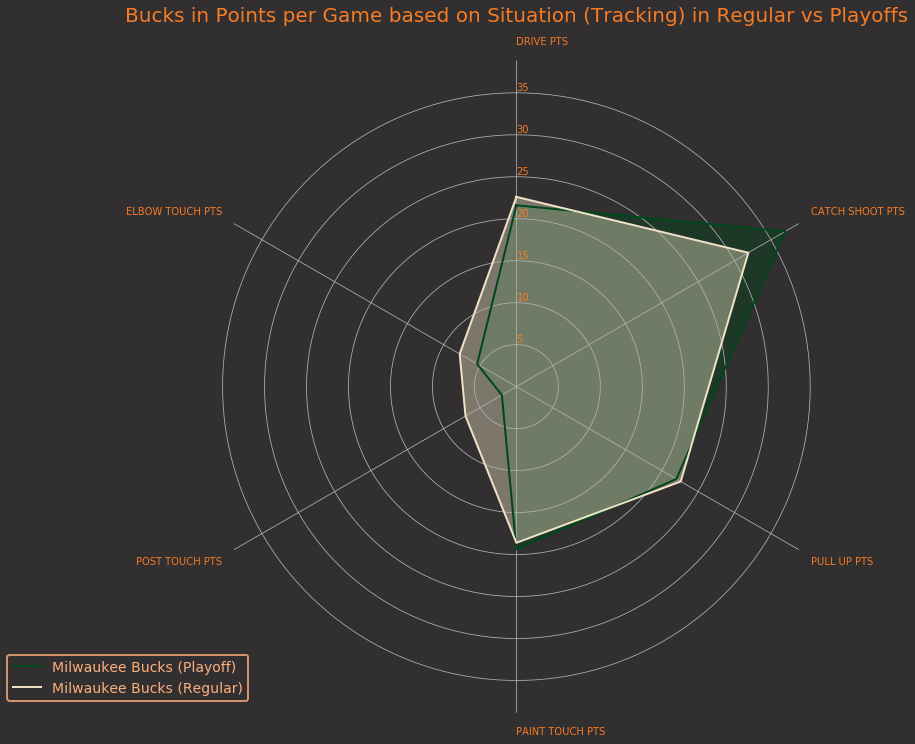

In [39]:
plot_radar(
    first_data=bucks_playoff_tracking,
    first_label='Milwaukee Bucks (Playoff)',
    first_color=bucks_color,
    second_data=bucks_regular_tracking,
    second_label='Milwaukee Bucks (Regular)',
    second_color=bucks_cream,
    title='Bucks in Points per Game based on Situation (Tracking) in Regular vs Playoffs'
)

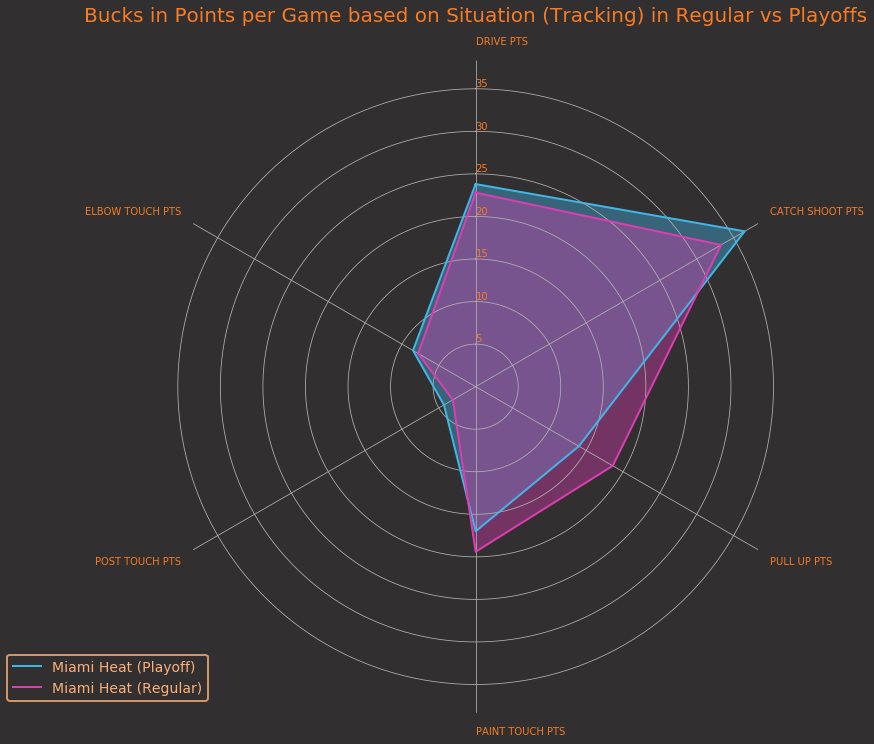

In [40]:
plot_radar(
    first_data=miami_playoff_tracking,
    first_label='Miami Heat (Playoff)',
    first_color=miami_secondary_blue,
    second_data=miami_regular_tracking,
    second_label='Miami Heat (Regular)',
    second_color=miami_secondary,
    title='Bucks in Points per Game based on Situation (Tracking) in Regular vs Playoffs'
)

### Playtype

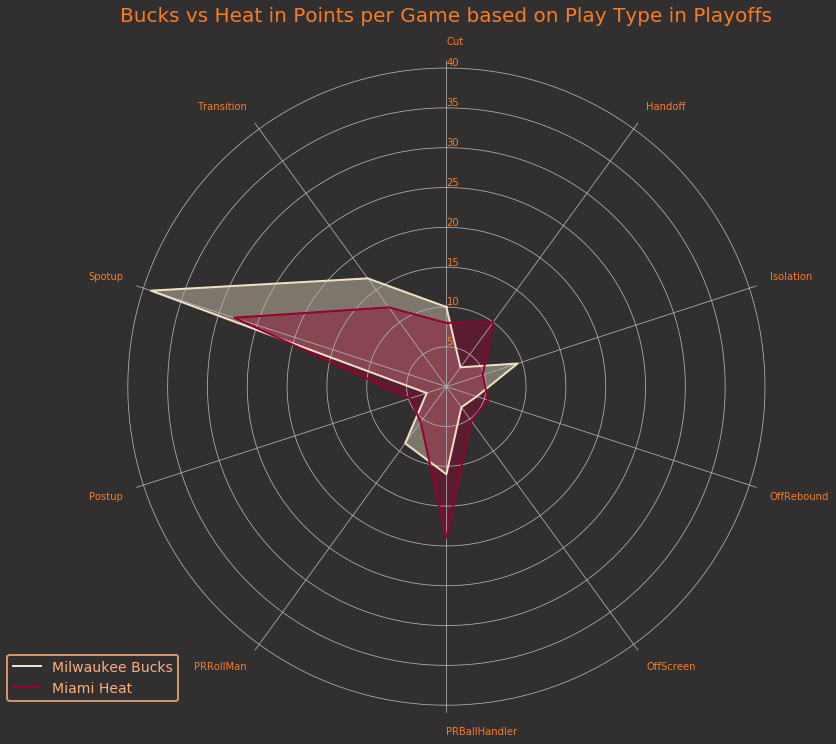

In [31]:
plot_radar(
    first_data=bucks_playoff_playtype,
    first_label='Milwaukee Bucks',
    first_color=bucks_cream,
    second_data=miami_playoff_playtype,
    second_label='Miami Heat',
    second_color=miami_color,
    title='Bucks vs Heat in Points per Game based on Play Type in Playoffs'
)

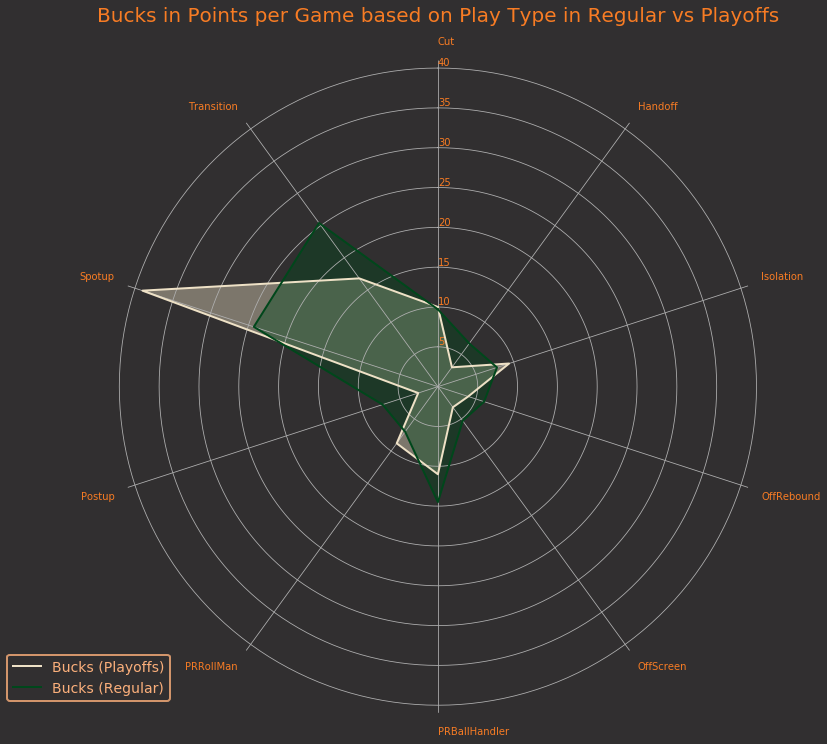

In [44]:
plot_radar(
    first_data=bucks_playoff_playtype,
    first_label='Bucks (Playoffs)',
    first_color=bucks_cream,
    second_data=bucks_regular_playtype,
    second_label='Bucks (Regular)',
    second_color=bucks_color,
    title='Bucks in Points per Game based on Play Type in Regular vs Playoffs'
)

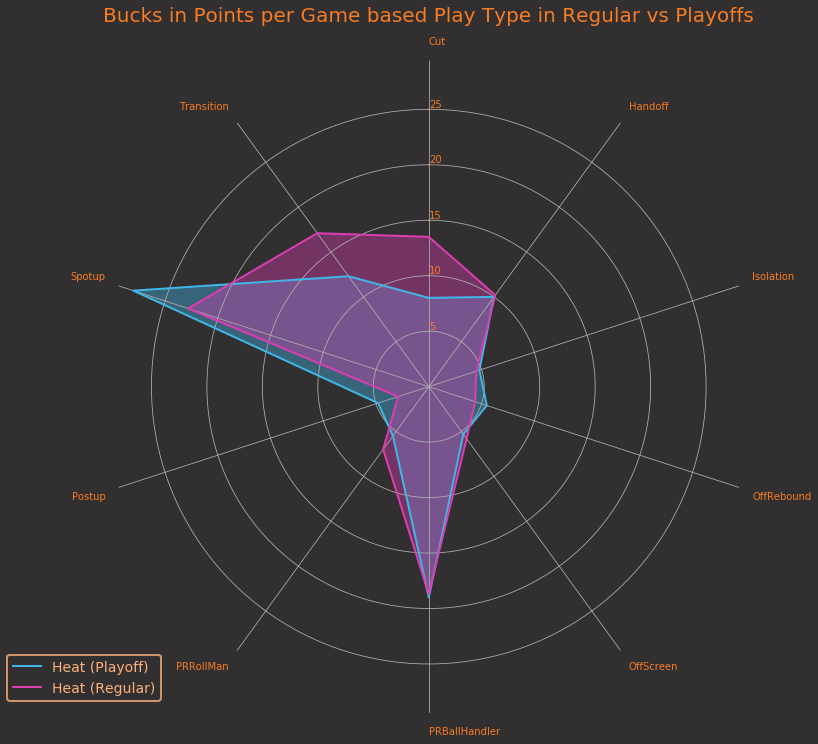

In [43]:
plot_radar(
    first_data=miami_playoff_playtype,
    first_label='Heat (Playoff)',
    first_color=miami_secondary_blue,
    second_data=miami_regular_playtype,
    second_label='Heat (Regular)',
    second_color=miami_secondary,
    title='Bucks in Points per Game based Play Type in Regular vs Playoffs'
)